In [363]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import collections
import random
import time
import urllib
pd.set_option('display.max_colwidth', None)

In [364]:
#Publicly accessible DAP collections can be accessed using /ws/v2 without authentication.
# https://data.csiro.au/dap/swagger-ui.html#/
# csiro_service ='https://data.csiro.au/dap/ws/v2/collections'
csiro_base_url = 'https://data.csiro.au/dap/ws/v2/collections/search'

In [365]:
# FOR codes
# 05 Environmental Sciences
# 04 Earth Sciences
fields_of_research = ['Environmental Sciences','Earth Sciences', 'Agricultural and Veterinary Sciences']

Query datasets by FOR

In [366]:
test_dataset = 'https://data.csiro.au/collections/#collection/CIcsiro:13481'
test_dataset ='https://doi.org/10.4225/08/58c8f798f241a'

In [367]:
datasets = []
data_dir = 'results'
#max_dataset = 500

In [368]:
# soud -> Show Only Unrestricted Data
for s in fields_of_research:
    try:
        payload = {'for' : s, 'soud' : 'on'}
        params = urllib.parse.urlencode(payload, quote_via=urllib.parse.quote)
        r = requests.get(csiro_base_url, params=params, headers={'Content-Type': 'application/json'})
        response = r.json()
        total_results = response['totalResults']
        print(r.url, total_results)
        for resp in response['dataCollections']:
            if resp['collectionType'] =='Data':
                datasets.append('https://doi.org/'+resp['doi'])
                #datasets.append(resp['landingPage']['href'])
    except requests.exceptions.RequestException as e:
        print(e)
    except requests.exceptions.ConnectionError as e1:
        print(e1)

https://data.csiro.au/dap/ws/v2/collections/search?for=Environmental%20Sciences&soud=on 36
https://data.csiro.au/dap/ws/v2/collections/search?for=Earth%20Sciences&soud=on 11
https://data.csiro.au/dap/ws/v2/collections/search?for=Agricultural%20and%20Veterinary%20Sciences&soud=on 5


In [369]:
datasets[:3]

['https://doi.org/10.4225/08/55E799BA0F73E',
 'https://doi.org/10.4225/08/58c90558ae31f',
 'https://doi.org/10.4225/08/58c8f798f241a']

In [370]:
[item for item, count in collections.Counter(datasets).items() if count > 1]

[]

In [371]:
print(len(datasets))
datasets = list(set(datasets))
print(len(datasets))

39
39


In [372]:
#random.seed(388)
#random.shuffle(datasets)
#datasets = datasets[:max_dataset]
#datasets[:10]

In [373]:
print('Total datasets :', len(datasets))

Total datasets : 39


In [374]:
testr = requests.get('https://doi.org/10.4225/08/58c8f798f241a')
if testr.history:
    print("Request was redirected")
    for res in testr.history:
        print(res.status_code, res.url)
    print("Final destination:")
    print(testr.status_code, testr.url)
else:
    print("Request was not redirected")

Request was redirected
302 https://doi.org/10.4225/08/58c8f798f241a
Final destination:
200 https://data.csiro.au/collections/#collection/CIcsiro:9973v2


Get info of all metrics implemented

In [375]:
metrics = []
try:
    request = requests.get('http://localhost:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [376]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics.head()

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,"Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.",2
3,FsF-F3-01M,Metadata includes the identifier of the data it describes.,1
4,FsF-F4-01M,Metadata is offered in such a way that it can be retrieved programmatically.,2


Run FAIR assessment for all datasets

In [377]:
%%time
fuji_service = 'http://localhost:1071/fuji/api/v1/evaluate'
all_records = []
for d in datasets:
    req = {'object_identifier':d, 'test_debug':True, 'oaipmh_endpoint':'https://data.csiro.au/oaiprovider/'}
    r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    json_data = r.json()
    records = {}
    records['identifier'] = d
    records['result'] = json_data
    all_records.append(records)

Wall time: 6min 53s


In [378]:
timestr = time.strftime("%Y%m%d")
timestr

'20200828'

In [379]:
file_name = data_dir+'/'+'csiro_'+timestr+'.json'
with open(file_name, 'w') as f:
    json.dump(all_records, f)

In [380]:
#file_name = 'results/csiro_20200828.json'
with open(file_name) as json_file:
    data = json.load(json_file)

In [381]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [382]:
get_assessment_result(test_dataset)

[{'id': 1,
  'metric_identifier': 'FsF-F1-01D',
  'metric_name': 'Data is assigned a globally unique identifier.',
  'output': {'guid': 'https://doi.org/10.4225/08/58c8f798f241a',
   'guid_scheme': 'doi'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ["INFO: Unique identifier schemes found ['doi', 'url']",
   'INFO: Finalized unique identifier scheme - doi'],
  'test_status': 'pass'},
 {'id': 2,
  'metric_identifier': 'FsF-F1-02D',
  'metric_name': 'Data is assigned a persistent identifier.',
  'output': {'pid': 'https://doi.org/10.4225/08/58c8f798f241a',
   'pid_scheme': 'doi',
   'resolvable_status': True,
   'resolved_url': 'https://data.csiro.au/collections/#collection/CIcsiro:9973v2'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ['INFO: Persistence identifier scheme - doi',
   'INFO: Retrieving page http://doi.org/10.4225/08/58c8f798f241a',
   'INFO: Content negotiation accept=text/html, application/xhtml+xml, status=200',
   'INFO: Found HTML page!',
   'INFO: 

In [383]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [384]:
df_results = pd.DataFrame.from_dict(final)

In [385]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [386]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://doi.org/10.4225/08/58c8f7d49ddfe,2,1,0,2,0,0,1,1,1,...,1,1,5,7,0,1,2,4,3,9
1,https://doi.org/10.4225/08/551485612CDEE,2,1,0,2,0,0,1,1,1,...,1,1,5,7,0,1,2,4,3,9
2,https://doi.org/10.25919/5c7e431416819,2,1,0,2,0,0,1,0,1,...,1,1,5,7,0,1,1,4,3,9
3,https://doi.org/10.4225/08/551484A8DE81A,2,1,0,2,0,0,1,1,1,...,1,1,5,7,0,1,2,4,3,9
4,https://doi.org/10.4225/08/54F7EFFAE4125,2,1,0,2,0,0,1,1,1,...,1,1,5,7,0,1,2,4,3,9


In [387]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] ).round(2)
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] ).round(2)
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] ).round(2)
df_results ['R_Principle' ]= (df_results ['R_earned'] / df_results ['R_total'] ).round(2)

In [388]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/58c8f7d49ddfe,2,1,0,2,0,0,1,1,1,...,0,1,2,4,3,9,0.71,0.0,0.50,0.33
1,https://doi.org/10.4225/08/551485612CDEE,2,1,0,2,0,0,1,1,1,...,0,1,2,4,3,9,0.71,0.0,0.50,0.33
2,https://doi.org/10.25919/5c7e431416819,2,1,0,2,0,0,1,0,1,...,0,1,1,4,3,9,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/551484A8DE81A,2,1,0,2,0,0,1,1,1,...,0,1,2,4,3,9,0.71,0.0,0.50,0.33
4,https://doi.org/10.4225/08/54F7EFFAE4125,2,1,0,2,0,0,1,1,1,...,0,1,2,4,3,9,0.71,0.0,0.50,0.33


In [389]:
df_results[df_results.identifier ==test_dataset]

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
21,https://doi.org/10.4225/08/58c8f798f241a,2,1,0,2,0,0,1,1,1,...,0,1,2,4,3,9,0.71,0.0,0.5,0.33


In [390]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/58c8f7d49ddfe,0.71,0.0,0.50,0.33
1,https://doi.org/10.4225/08/551485612CDEE,0.71,0.0,0.50,0.33
2,https://doi.org/10.25919/5c7e431416819,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/551484A8DE81A,0.71,0.0,0.50,0.33
4,https://doi.org/10.4225/08/54F7EFFAE4125,0.71,0.0,0.50,0.33
5,https://doi.org/10.4225/08/551484C9C7758,0.71,0.0,0.50,0.33
6,https://doi.org/10.4225/08/5208441EA2C6F,0.71,0.0,0.25,0.33
7,https://doi.org/10.25919/5c12fe7dae432,0.71,0.0,0.25,0.33
8,https://doi.org/10.4225/08/57988C158CB9C,0.71,0.0,0.50,0.33
9,https://doi.org/10.25919/5b5016c4bca25,0.71,0.0,0.25,0.33


In [391]:
timestr

'20200828'

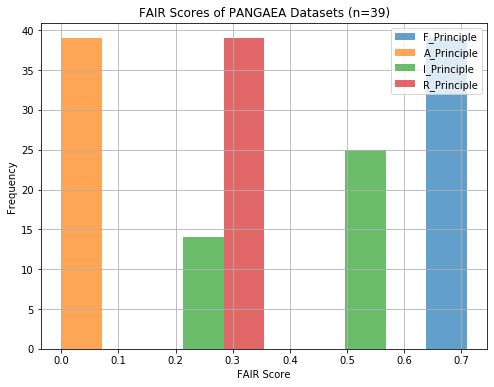

In [392]:
title = "FAIR Scores of PANGAEA Datasets (n="+str(len(df_hist))+")"
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.7,figsize = (8,6), title=title)
plt.xlabel('FAIR Score')
fig_name = data_dir+'/'+'pangaea_'+timestr+'.png'
plt.savefig(fig_name)

In [393]:
principles = {}
principles['F_Principle'] = 'Findability'
principles['A_Principle'] = 'Accessibility'
principles['I_Principle'] = 'Interoperability'
principles['R_Principle'] = 'Reusability'
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,4))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=20, ax=ax, color=c, range=(0, 1.0))
        ax.set_title(principles.get(feature))
        ax.set(xlabel="Score", ylabel="Frequency")
    #fig.tight_layout()  
    fig_name = data_dir+'/'+'sub_csiro_'+timestr+'.png'
    fig.subplots_adjust(top=0.8)
    plt.savefig(fig_name)
    plt.suptitle('FAIR Scores of CSIRO Datasets By Principle '+ ' (n=' + str(len(df_hist))+')',fontsize=15)
    plt.show()

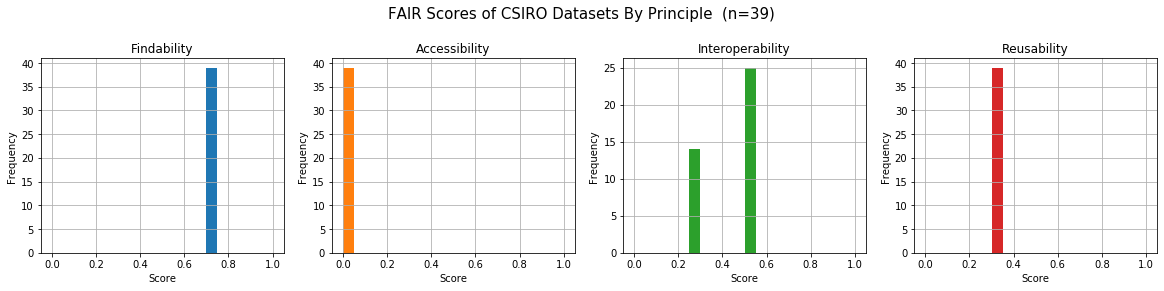

In [394]:
histograms_plot(df_hist,df_hist.columns[1:],1,4)

Inspect FINDABILITY 

In [395]:
#Missing core metadata ['keywords']" - seems like keywords are not sent to datacite service as part of the registration
# Data (content) identifier is missing
df_hist[df_hist.F_Principle <0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/58c8f7d49ddfe,0.71,0.0,0.50,0.33
1,https://doi.org/10.4225/08/551485612CDEE,0.71,0.0,0.50,0.33
2,https://doi.org/10.25919/5c7e431416819,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/551484A8DE81A,0.71,0.0,0.50,0.33
4,https://doi.org/10.4225/08/54F7EFFAE4125,0.71,0.0,0.50,0.33
5,https://doi.org/10.4225/08/551484C9C7758,0.71,0.0,0.50,0.33
6,https://doi.org/10.4225/08/5208441EA2C6F,0.71,0.0,0.25,0.33
7,https://doi.org/10.25919/5c12fe7dae432,0.71,0.0,0.25,0.33
8,https://doi.org/10.4225/08/57988C158CB9C,0.71,0.0,0.50,0.33
9,https://doi.org/10.25919/5b5016c4bca25,0.71,0.0,0.25,0.33


Inspect ACCESSBILITY

In [396]:
df_hist[df_hist.A_Principle <0.8].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/58c8f7d49ddfe,0.71,0.0,0.50,0.33
1,https://doi.org/10.4225/08/551485612CDEE,0.71,0.0,0.50,0.33
2,https://doi.org/10.25919/5c7e431416819,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/551484A8DE81A,0.71,0.0,0.50,0.33
4,https://doi.org/10.4225/08/54F7EFFAE4125,0.71,0.0,0.50,0.33


In [397]:
#For normal collections these should be accurate, e.g. accessLevel will be something like:
#•	Public
#•	CSIRO Users Only
#•	Specific Users
df_hist[df_hist.A_Principle > 0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Inspect INTEROPERABILITY

In [398]:
#NO RDF metadata available (sparql, content-negotiation)
#Total number of related resources extracted - 0
df_hist[df_hist.I_Principle < 0.3]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
2,https://doi.org/10.25919/5c7e431416819,0.71,0.0,0.25,0.33
6,https://doi.org/10.4225/08/5208441EA2C6F,0.71,0.0,0.25,0.33
7,https://doi.org/10.25919/5c12fe7dae432,0.71,0.0,0.25,0.33
9,https://doi.org/10.25919/5b5016c4bca25,0.71,0.0,0.25,0.33
12,https://doi.org/10.25919/5c53c7d61cf79,0.71,0.0,0.25,0.33
14,https://doi.org/10.25919/5de850a1d2172,0.71,0.0,0.25,0.33
19,https://doi.org/10.25919/5d75e59e8908c,0.71,0.0,0.25,0.33
20,https://doi.org/10.4225/08/55E799BA0F73E,0.71,0.0,0.25,0.33
26,https://doi.org/10.4225/08/58046aaadaeda,0.71,0.0,0.25,0.33
27,https://doi.org/10.25919/5c6269bc895ed,0.71,0.0,0.25,0.33


In [399]:
##NO RDF metadata available (sparql, content-negotiation)
df_hist[df_hist.I_Principle > 0.3] 

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/58c8f7d49ddfe,0.71,0.0,0.5,0.33
1,https://doi.org/10.4225/08/551485612CDEE,0.71,0.0,0.5,0.33
3,https://doi.org/10.4225/08/551484A8DE81A,0.71,0.0,0.5,0.33
4,https://doi.org/10.4225/08/54F7EFFAE4125,0.71,0.0,0.5,0.33
5,https://doi.org/10.4225/08/551484C9C7758,0.71,0.0,0.5,0.33
8,https://doi.org/10.4225/08/57988C158CB9C,0.71,0.0,0.5,0.33
10,https://doi.org/10.4225/08/519F04075BB7F,0.71,0.0,0.5,0.33
11,https://doi.org/10.4225/08/55148491CB988,0.71,0.0,0.5,0.33
13,https://doi.org/10.4225/08/58c8f729e5328,0.71,0.0,0.5,0.33
15,https://doi.org/10.25919/5f2b593653ad6,0.71,0.0,0.5,0.33


Inspect REUSABILITY

In [400]:
#"INFO: Resource type specified - Dataset",
# "WARNING: NO object content available to perform file descriptors (type and size) tests",
# "WARNING: NO measured variables found in metadata, skip 'measured_variable' test.
# "WARNING: NO license information is included in metadata"
#Unable to determine community standard
#structured_provenance_unavailable
#Could not perform file format checks, no object content identifiers available
df_hist[df_hist.R_Principle < 0.5] 

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/58c8f7d49ddfe,0.71,0.0,0.50,0.33
1,https://doi.org/10.4225/08/551485612CDEE,0.71,0.0,0.50,0.33
2,https://doi.org/10.25919/5c7e431416819,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/551484A8DE81A,0.71,0.0,0.50,0.33
4,https://doi.org/10.4225/08/54F7EFFAE4125,0.71,0.0,0.50,0.33
5,https://doi.org/10.4225/08/551484C9C7758,0.71,0.0,0.50,0.33
6,https://doi.org/10.4225/08/5208441EA2C6F,0.71,0.0,0.25,0.33
7,https://doi.org/10.25919/5c12fe7dae432,0.71,0.0,0.25,0.33
8,https://doi.org/10.4225/08/57988C158CB9C,0.71,0.0,0.50,0.33
9,https://doi.org/10.25919/5b5016c4bca25,0.71,0.0,0.25,0.33
